In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle

import time

from abc import ABC, abstractmethod

import os

from skopt import Optimizer
from skopt.space import Real

import scipy.stats as st

from rich.table import Table
from rich.console import Console

from joblib import Parallel, delayed


import math
import random

from collections import namedtuple, deque
from itertools import count

import tensorflow as tf
import keras

import sklearn
import sklearn.neural_network

2024-09-15 10:24:44.322347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 10:24:44.338772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 10:24:44.343652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 10:24:44.356774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 10:24:45.154455: W tensorflow/compiler/tf2

# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gym.farama.org/environments/classic_control/mountain_car/

## Description
The Mountain Car MDP is a deterministic environment where a car must reach the top of a hill by overcoming gravity. The car is initially placed in a valley, and the agent needs to apply strategic accelerations to reach the goal.

## Observation Space
- **Shape:** `(2,)`
- **Elements:**
  - Position: `[-1.2, 0.6]` (meters)
  - Velocity: `[-0.07, 0.07]` (meters/second)

## Action Space
- **Discrete(3)**
  1. Accelerate left
  2. No acceleration
  3. Accelerate right

## Transition Dynamics
- Updates based on applied force, velocity, and gravity. Inelastic collisions occur at boundaries.

## Reward
- Constant reward of `-1` per timestep until the goal is reached.

## Starting State
- Position: Uniform random in `[-0.6, -0.4]`
- Velocity: `0`

## Episode End
1. **Termination:** Position ≥ 0.5 (goal reached)
2. **Truncation:** 200 timesteps


In [4]:
PROBLEM_NAME = 'MountainCar-v0'

MAX_EPISODE_STEPS = 200
SPACE_RANGE = [-1.2, 0.6]
VEL_RANGE = [-0.07, 0.07]
ACTION_SPACE = 3

In [5]:
class Learner(ABC) :

    def __init__(self, alpha : float, gamma : float) :
        
        self.env : gym.Env = None
        self.rng = None

        self.alpha = alpha
        self.gamma = gamma


    def oneEpisode(self, episodeIdx : int, training : bool) -> tuple[list, list, list]:
        currentState = self.env.reset()[0]
        terminated = False
        totalReward = 0
        spaceArray = []
        velArray = []
        for episodeStep in range(0, MAX_EPISODE_STEPS) :

            if (not training) :
                spaceArray.append(currentState[0])
                velArray.append(currentState[1])

            action = self.chooseNextAction(currentState, episodeIdx, episodeStep, training)
            nextState, reward, terminated, _, _ = self.env.step(action)
            if training :
                self.updateFunction(currentState, nextState, reward, action, episodeIdx, episodeStep)

            currentState = nextState
            totalReward += reward
            if (terminated) :
                break

        if (not training) :
            spaceArray.append(currentState[0])
            velArray.append(currentState[1])
        
        return totalReward, spaceArray, velArray


    def learn(self, episodeNum : int, seed : int) -> np.ndarray :
        self.env : gym.Env = gym.make(PROBLEM_NAME)

        self.env.reset(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray= np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            print("Episode Idx >>> ", episodeIdx)
            episodeReward, _, _  = self.oneEpisode(episodeIdx, True)
            rewardArray[episodeIdx] = episodeReward

            self.updateAfterEpisode(episodeNum, episodeIdx)

            print("Episode Reward >>> ", episodeReward)
        
        self.env.close()
        self.env = None
        self.rng = None

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) -> tuple[np.ndarray, list, list]:
        self.env : gym.Env = gym.make(PROBLEM_NAME)
        
        self.env.reset(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray = np.zeros(episodeNum)
        spaceMatrix = []
        velMatrix = []
        for episodeIdx in range(0, episodeNum) :
            episodeReward, spaceArray, velArray  = self.oneEpisode(episodeIdx, False)
            rewardArray[episodeIdx] = episodeReward
            spaceMatrix.append(spaceArray)
            velMatrix.append(velArray)

        self.env.close()
        self.env = None
        self.rng = None
        return rewardArray, spaceMatrix, velMatrix


    @abstractmethod
    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx) :
        pass

    @abstractmethod
    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int : 
        pass

    @abstractmethod
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None:
        pass


In [6]:
class QFunction(ABC) :

    @abstractmethod
    def updateFunction(self, currentState, action, reward, nextState, alpha, gamma, target) :
        pass

    @abstractmethod
    def getValue(self, state, action) -> float :
        pass

    @abstractmethod
    def getValues(self, state) -> np.ndarray :
        pass

In [7]:
TRAIN_SEED = 0
TUNE_SEED = 1
TEST_SEED = 2

TUNER_RANDOM_STATE = 3

KERAS_RANDOM_STATE = 4

# Utils

In [8]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table:
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

In [9]:
class BucketQFunction(QFunction) :

    def __init__(self, spaceRange : list, spaceBins : int, velRange : list, velBins : int, actionSpace : int) :
        self.q : np.ndarray = np.zeros([spaceBins, velBins, actionSpace])

        self.spaceLinSpace = np.linspace(
            spaceRange[0], 
            spaceRange[1], 
            spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            velRange[0], 
            velRange[1], 
            velBins + 1
        )

    def updateFunction(self, currentState, action, reward, nextState, alpha, gamma, target):
        spaceSlot, velSlot = self._computeSlots(currentState)
        increment = alpha * (target - self.getValue(currentState, action))

        self.q[spaceSlot, velSlot, action] += increment
    
    def getValue(self, state, action):
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, action]
    
    def getValues(self, state) :
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, :]
    
    def _computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return spaceSlot, velocitySlot

## Algoritmi

### Q-Learning
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [10]:
class QLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, explorePerc : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon
        self.baseEpsilon = epsilon
        self.explorePerc = explorePerc

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        target = reward + self.gamma * np.max(self.q.getValues(nextState))
        self.q.updateFunction(currentState, action, reward, nextState, self.alpha, self.gamma, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (episodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (episodeIdx / exploreEpisodeNum) * self.baseEpsilon
        else :
            self.epsilon = 0

### SARSA
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata

In [11]:
class SarsaLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, explorePerc : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon

        self.baseEpsilon = epsilon
        self.explorePerc = explorePerc

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        nextAction = self.chooseNextAction(nextState, episodeIdx, episodeStep, True)
        target = reward + self.gamma * self.q.getValue(nextState, nextAction)
        self.q.updateFunction(currentState, action, reward, nextState, self.alpha, self.gamma, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (episodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (episodeIdx / exploreEpisodeNum) * self.baseEpsilon
        else :
            self.epsilon = 0

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri; come iperparametri da sintonizzare sono stati considerati solamente due dei possibili, ovvero:
* $\alpha$, cioè il learning rate
* $\gamma$, cioè il fattore di sconto

Per quanto riguarda gli altri valori sono stati scelti empiricamente facendo qualche prova manuale:
* Per il parametro di esplorazione $\epsilon$ si è scelta un'inizializzazione ad $1$ con decremento lineare
* Numero di beans: Il numero di intervalli in cui suddividere lo stato dello spazio e della velocità sono stati supposti uguali e posti al valore $20$. La scelta è stata dettata dal fatto che si tratta di un valore che permette una suddivisione non eccessivamente fitta dei due stati pur mantenendo una grana abbastanza fine; lo spazio infatti è suddiviso in intervalli di dimensione $0.09$, mentre la velocità in intervalli di dimensione $0.007$

Essendo le singole Run di sintonizzazione piuttosto lunghe, i valori una volta calcolati vengono salvati su un file in modo tale da non doverli calcolare una seconda

In [12]:
TRAIN_EPISODES = 10_000

In [13]:
class Tuner() :

    def __init__(self, LearnerClass : Learner, trainEpisodes : int, tuneEpisodes : int, trainSeed : int, tuneSeed : int, withStd : bool) :
        self.LearnerClass = LearnerClass
        self.trainEpisodes = trainEpisodes
        self.tuneEpisodes = tuneEpisodes
        self.trainSeed = trainSeed
        self.tuneSeed = tuneSeed
        self.withStd = withStd

    def objective(self, params):
        alpha, gamma, epsilon = params
        learner : Learner = self.LearnerClass(
            alpha, gamma, epsilon, 0.5,
            BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        )
        trainRewardArray = learner.learn(self.trainEpisodes, self.trainSeed)
        tuneRewardArray, _, _ = learner.test(self.tuneEpisodes, self.tuneSeed, False)
        
        meanTune = -tuneRewardArray.mean()
        stdDev = np.sqrt(tuneRewardArray.var())
        if (self.withStd) :
            objValue = meanTune + stdDev
        else :
            objValue = meanTune
        return objValue
    
    def tune(self, calls, randomState, space, jobsNum) :

        optimizer = Optimizer(
            dimensions = space, 
            random_state = randomState,
        )

        for i in range(calls // jobsNum):
            print(f"Step >>> {i}")
            x = optimizer.ask(n_points=jobsNum)  # x is a list of n_points points
            # for params in x :
            #     print(f"Attempt >>> {params}")
                
            y = Parallel(
                n_jobs = jobsNum
            )(delayed(self.objective)(params) for params in x)  # evaluate points in parallel
            optimizer.tell(x, y)

            bestIdx = np.argmin(optimizer.yi)
            print(f"Best Value So Far >>> {optimizer.yi[bestIdx]}")
            print(f"Best Params So Far >>> {optimizer.Xi[bestIdx]}")
            print()
        
        bestIdx = np.argmin(optimizer.yi)
        print(f"Best Value >>> {optimizer.yi[bestIdx]}")
        print(f"Best Params >>> {optimizer.Xi[bestIdx]}")
        print()
        print()

        return optimizer.Xi[bestIdx]

In [14]:
def tuneLearner(LearnerClass, trainEpisodes, bestDict, fileName : str, withStd : bool) -> list :
    key = (LearnerClass.__name__, withStd)
    if (not key in bestDict) :
        space = [
            Real(0.01, 0.9, name = 'alpha'),
            Real(0.8, 1.0, name = 'gamma'),
            Real(0.5, 1.0, name = "epsilon"),
        ]
        bestParams = Tuner(LearnerClass, trainEpisodes, 100, TRAIN_SEED, TUNE_SEED, withStd).tune(75, TUNER_RANDOM_STATE, space, 5)
        bestDict[key] = bestParams
        with open(fileName, 'wb') as f:
            pickle.dump(bestDict, f)
    else :
        bestParams = bestDict[key]

    return bestParams

In [15]:
BEST_PARAMS_FILE_NAME = './BestParamsDict.pkl'

if (os.path.exists(BEST_PARAMS_FILE_NAME)) :
    with open(BEST_PARAMS_FILE_NAME, 'rb') as f:
        bestDict = pickle.load(f)
else :
    bestDict = {}

tuneLearner(QLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, False)
tuneLearner(SarsaLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, False)

tuneLearner(QLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, True)
tuneLearner(SarsaLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, True)


[0.09312125864801411, 1.0, 0.6806313017402588]

In [16]:
table = buildTable("Best Params", ["LearnerName", "With Std", "Alpha", "Gamma", "Epsilon"], [False, False, True, True, True])
for key in bestDict :
    table.add_row(key[0], str(key[1]), str(bestDict[key][0]), str(bestDict[key][1]), str(bestDict[key][2]))

Console().print(table)

                                        Best Params                                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ With Std ┃ Alpha               ┃ Gamma              ┃ Epsilon            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ QLearner     │ True     │ 0.1971257270556444  │ 0.9523381293045927 │ 1.0                │
│ SarsaLearner │ True     │ 0.09312125864801411 │ 1.0                │ 0.6806313017402588 │
│ QLearner     │ False    │ 0.31967146010747477 │ 0.9561574341248738 │ 0.853578635665807  │
│ SarsaLearner │ False    │ 0.09420890896587364 │ 1.0                │ 0.8847231481964678 │
└──────────────┴──────────┴─────────────────────┴────────────────────┴────────────────────┘

## Addestramento

In [17]:
def plotTrainTrend(rewardArray : np.ndarray, episodeNum : int, learnerName : str) :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

    axes[0].plot(np.array(rewardArray))
    axes[0].set_xlabel("Episode Idx")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Reward During Training")
    axes[0].grid(True)
    
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    axes[1].plot(mean_rewards)
    axes[1].set_xlabel("Episode Idx")
    axes[1].set_ylabel("Avg Reward - 100 Episodes")
    axes[1].set_title("Avg Reward Trend During Training")
    axes[1].grid(True)

    fig.suptitle(f"{learnerName} - Training")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [18]:
TRAINED_TABULAR_FILE = "./TabularTrained.pkl"
def trainLearner(LearnerClass, trainDict, bestParamsDict, episodeNum, withStd) -> tuple[Learner, np.ndarray] :
    key = (LearnerClass.__name__, withStd)
    if (not key in trainDict) :
        alpha, gamma, epsilon = bestParamsDict[key]
        learner = LearnerClass(
            alpha, 
            gamma, 
            epsilon, 
            0.5,
            BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        )

        rewardArray = learner.learn(episodeNum, TRAIN_SEED)
        
        trainDict[key] = [learner, rewardArray]
        with open(TRAINED_TABULAR_FILE, 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        learner : Learner = trainDict[key][0]
        rewardArray = trainDict[key][1]
    
    plotTrainTrend(rewardArray, episodeNum, key)

    return learner, rewardArray

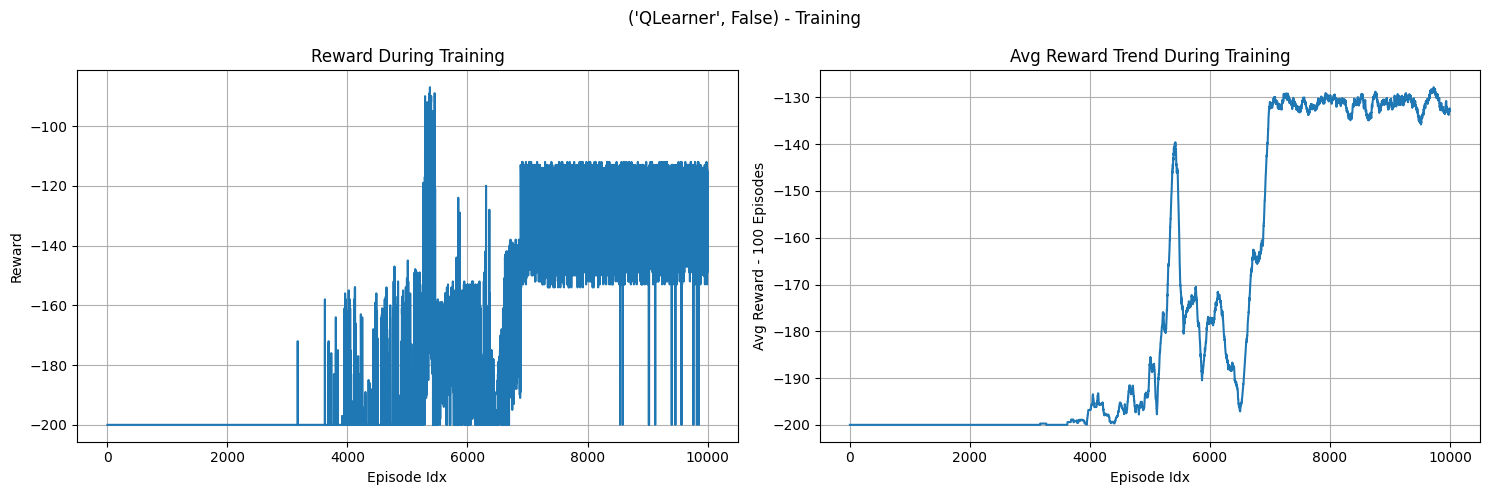

<Figure size 640x480 with 0 Axes>

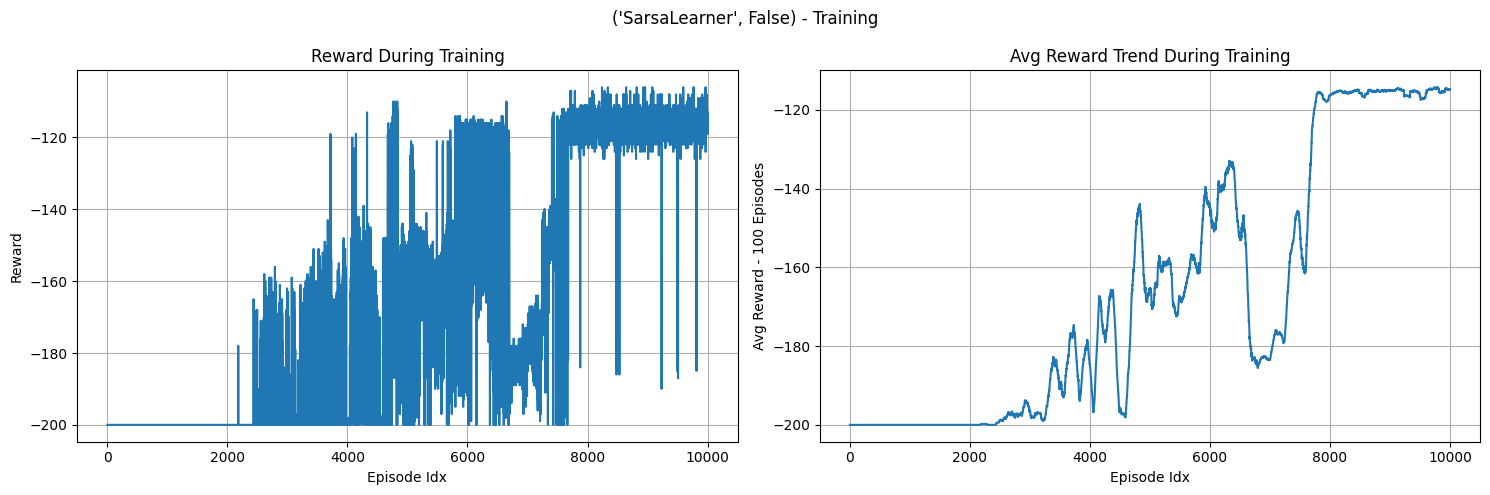

<Figure size 640x480 with 0 Axes>

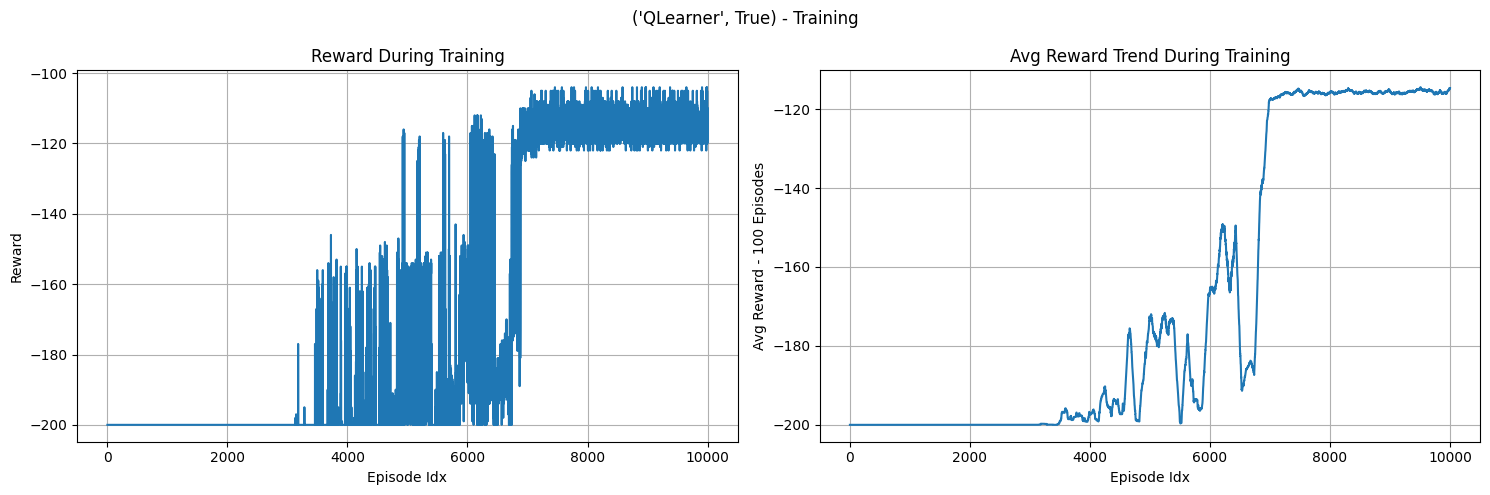

<Figure size 640x480 with 0 Axes>

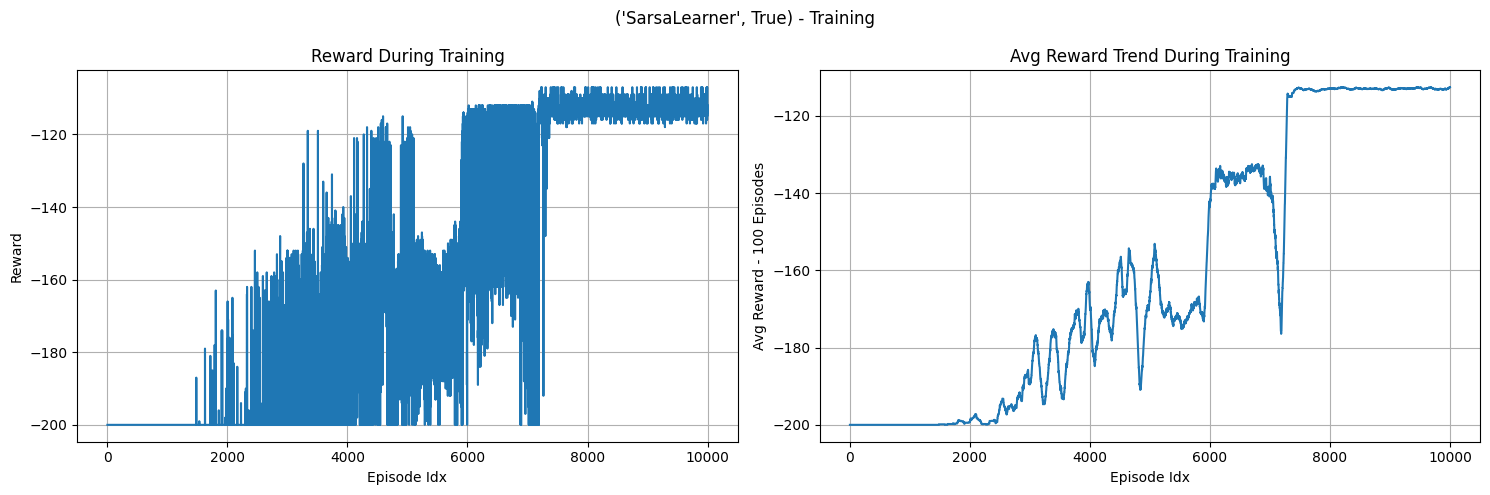

<Figure size 640x480 with 0 Axes>

In [19]:
if (os.path.exists(TRAINED_TABULAR_FILE)) :
    with open(TRAINED_TABULAR_FILE, 'rb') as f:
        trainDict = pickle.load(f)
else :
    trainDict = {}

qLearner, _ = trainLearner(QLearner, trainDict, bestDict, TRAIN_EPISODES, False)
sarsaLearner, _ = trainLearner(SarsaLearner, trainDict, bestDict, TRAIN_EPISODES, False)

qLearner_std, _ = trainLearner(QLearner, trainDict, bestDict, TRAIN_EPISODES, True)
sarsaLearner_std, _ = trainLearner(SarsaLearner, trainDict, bestDict, TRAIN_EPISODES, True)

## Testing

In [20]:
TESTING_EPISODES = 100

baseList = []
withStdList = []

for key in trainDict :
    if (key[1]) :
        withStdList.append(trainDict[key][0])
    else :
        baseList.append(trainDict[key][0])

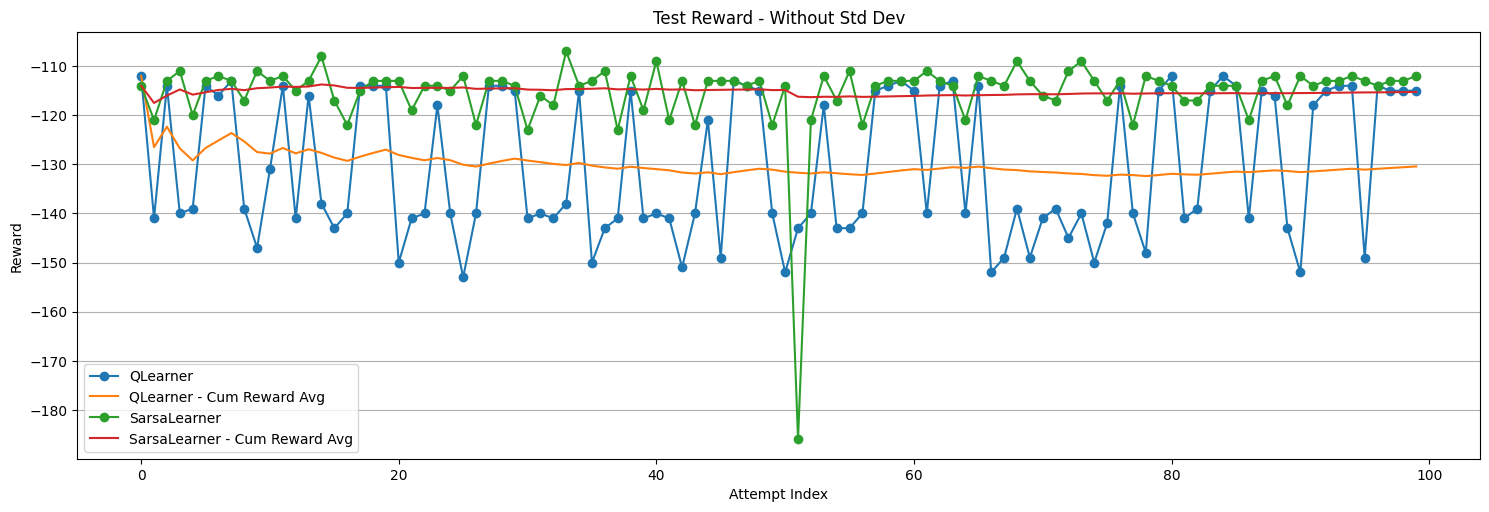

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize = (15, 5))
for learner in baseList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    plt.plot(rewardArray, label = learner.__class__.__name__, marker = "o")

    cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
    plt.plot(cumAvg, label = learner.__class__.__name__ + " - Cum Reward Avg")
plt.legend()
plt.grid(True, axis = "y")
plt.ylabel("Reward")
plt.xlabel("Attempt Index")
plt.tight_layout()
plt.title("Test Reward - Without Std Dev")
plt.show()
plt.clf()

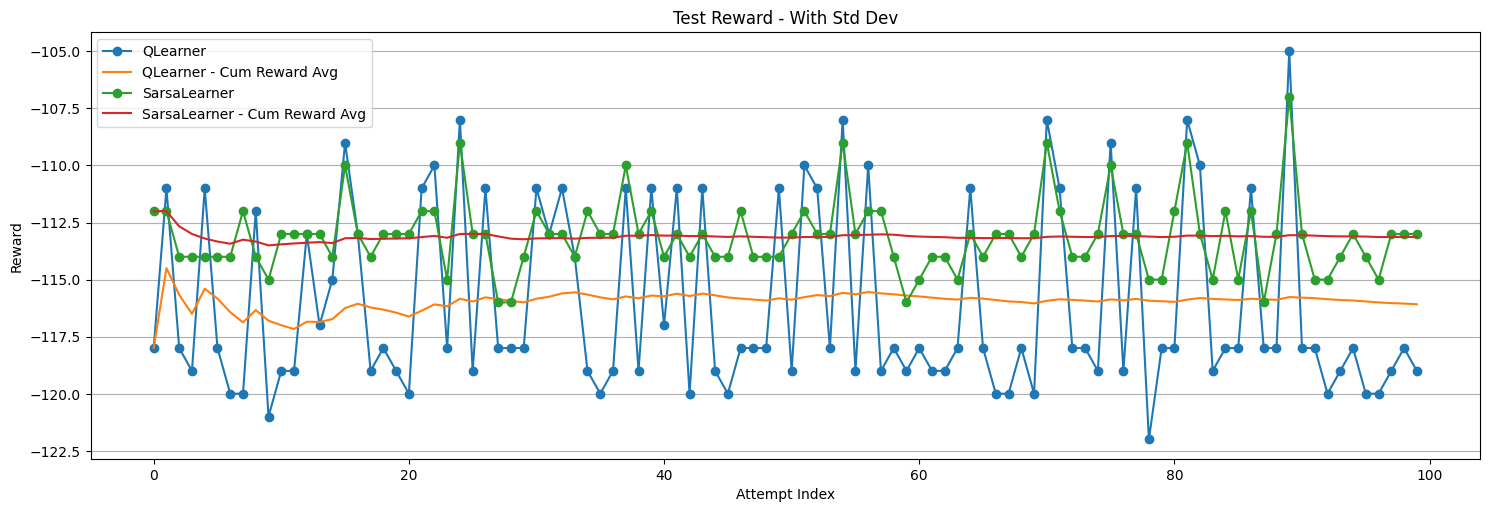

<Figure size 640x480 with 0 Axes>

In [22]:
plt.figure(figsize = (15, 5))
for learner in withStdList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    plt.plot(rewardArray, label = learner.__class__.__name__, marker = "o")

    cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
    plt.plot(cumAvg, label = learner.__class__.__name__ + " - Cum Reward Avg")
plt.legend()
plt.grid(True, axis = "y")
plt.ylabel("Reward")
plt.xlabel("Attempt Index")
plt.tight_layout()
plt.title("Test Reward - With Std Dev")
plt.show()
plt.clf()

In [23]:
table = buildTable("Testing Reward Info", ["LearnerName", "With Std", "Avg Reward", "Reward Std Dev", "Confidence Interval 95%"], [False, False, True, True, True])
for learner in baseList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(learner.__class__.__name__, str(False), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)

for learner in withStdList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(learner.__class__.__name__, str(True), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)


Console().print(table)

                                           Testing Reward Info                                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ With Std ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ QLearner     │ False    │ -130.43    │ 14.461849812523987 │ -133.3140009911711 / -127.54599900882891  │
│ SarsaLearner │ False    │ -115.26    │ 7.935515106154106  │ -116.84251079414352 / -113.67748920585649 │
│ QLearner     │ True     │ -116.08    │ 4.043958456759911  │ -116.88645148087835 / -115.27354851912165 │
│ SarsaLearner │ True     │ -113.13    │ 1.5726092966786125 │ -113.44361180133528 / -112.81638819866471 │
└──────────────┴──────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

# Soluzione con approssimazione

## Approssimazione con DQN

In [24]:
keras.utils.set_random_seed(KERAS_RANDOM_STATE)

In [25]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.rng = np.random.default_rng(seed = 0)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        indices = self.rng.choice(len(self.memory), size=batch_size, replace=True)  # Campionamento senza sostituzione
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)

In [31]:
class DQNFunction(QFunction) :

    def __init__(
            self, 
            policyNet : sklearn.neural_network.MLPRegressor, 
            targetNet : sklearn.neural_network.MLPRegressor, 
            updateTargetPeriod : int = 16, 
            batchSize : int = 128, 
            memoryCapacity : int = 10_000
        ) :
        self.policyNet = policyNet
        self.targetNet = targetNet

        self.updateTargetPeriod = updateTargetPeriod
        self.updateCount = 0
        self.batchSize = batchSize

        self.targetNet.set_params(**self.policyNet.get_params())

        self.replayMemory = ReplayMemory(memoryCapacity)

        self.weights = None
        

    def getValue(self, state, action) -> float:
        # convertedState = tf.convert_to_tensor([state])
        # return self.policyNet.predict_on_batch(convertedState)[action]
        convertedState = np.array([state])
        return self.policyNet.predict(convertedState)[action]
    
    def getValues(self, state) -> np.ndarray:
        # convertedState = tf.convert_to_tensor([state])
        # value = self.policyNet.predict_on_batch(convertedState)
        # return value
        convertedState = np.array([state])
        return self.policyNet.predict(convertedState)
    
    def updateFunction(self, currentState, action, reward, nextState, alpha, gamma, target):
        self.replayMemory.push(currentState, action, reward, nextState)

        if (len(self.replayMemory) < self.batchSize) :
            return
        
        batch = self.replayMemory.sample(self.batchSize)
        batch = np.array(batch, dtype = "object")
        batch = batch.T

        x = batch[0]
        x = np.vstack(x)

        nextStates = batch[3]
        nextStates = np.vstack(nextStates)

        rewards = batch[2]

        actions = np.array(batch[1], dtype = int)

        y = self.policyNet.predict(x)
        targets = rewards + gamma * np.max(self.targetNet.predict(nextStates), axis = 1)
        y[:, actions] = targets
        
        self.policyNet.partial_fit(x, y)
        self.updateCount += 1
        if (self.updateCount % self.updateTargetPeriod == 0) :
            self.targetNet.set_params(**self.policyNet.get_params())
    
    


In [32]:
# policyNet = keras.Sequential(
#     layers = [
#         keras.Input(shape = (2,)),
#         keras.layers.Dense(units = 64, activation = "relu"),
#         keras.layers.Dense(units = ACTION_SPACE, activation = None)
#     ]
# )
# policyNet.compile(
#     loss = keras.losses.mean_squared_error,
# )

# targetNet = keras.Sequential(
#     layers = [
#         keras.Input(shape = (2,)),
#         keras.layers.Dense(units = 64, activation = "relu"),
#         keras.layers.Dense(units = ACTION_SPACE, activation = None)
#     ]
# )
# targetNet.compile(
#     loss = keras.losses.mean_squared_error
# )


policyNet = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes = (128, 128),
    activation = "relu",
    solver = "adam",
    random_state = TRAIN_SEED,
    batch_size = 1024
)
policyNet.partial_fit([[0,0]], [[0,0,0]])

targetNet = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes = (128, 128),
    activation = "relu",
    solver = "adam",
    random_state = TRAIN_EPISODES,
    batch_size = 1024
)
targetNet.partial_fit([[0,0]], [[0,0,0]])

/home/simone/Scrivania/University/ML/ML_ENV/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/simone/Scrivania/University/ML/ML_ENV/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:608: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


MLPRegressor(batch_size=1024, hidden_layer_sizes=(128, 128), random_state=10000)

Episode Idx >>>  0
Episode Reward >>>  -200.0
Episode Idx >>>  1
Episode Reward >>>  -200.0
Episode Idx >>>  2
Episode Reward >>>  -200.0
Episode Idx >>>  3
Episode Reward >>>  -200.0
Episode Idx >>>  4
Episode Reward >>>  -200.0
Episode Idx >>>  5
Episode Reward >>>  -200.0
Episode Idx >>>  6
Episode Reward >>>  -200.0
Episode Idx >>>  7
Episode Reward >>>  -200.0
Episode Idx >>>  8
Episode Reward >>>  -200.0
Episode Idx >>>  9
Episode Reward >>>  -200.0
Episode Idx >>>  10
Episode Reward >>>  -200.0
Episode Idx >>>  11
Episode Reward >>>  -200.0
Episode Idx >>>  12
Episode Reward >>>  -200.0
Episode Idx >>>  13
Episode Reward >>>  -200.0
Episode Idx >>>  14
Episode Reward >>>  -200.0
Episode Idx >>>  15
Episode Reward >>>  -200.0
Episode Idx >>>  16
Episode Reward >>>  -200.0
Episode Idx >>>  17
Episode Reward >>>  -200.0
Episode Idx >>>  18
Episode Reward >>>  -200.0
Episode Idx >>>  19
Episode Reward >>>  -200.0
Episode Idx >>>  20
Episode Reward >>>  -200.0
Episode Idx >>>  21
Epi

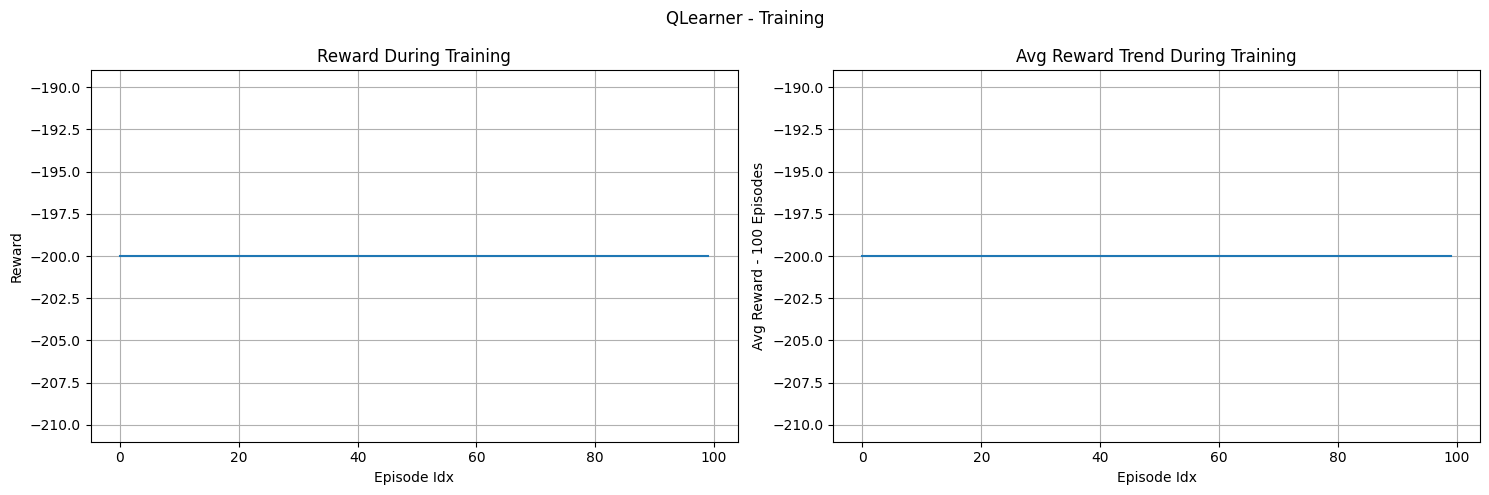

<Figure size 640x480 with 0 Axes>

In [33]:
learner = QLearner(0.9, 0.9, 0.9, 0.5, DQNFunction(policyNet, targetNet, updateTargetPeriod = 128, batchSize = 1024))
learnArray = learner.learn(100, 0)
plotTrainTrend(learnArray, 100, "QLearner")